In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


In [2]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


In [3]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3,3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)


In [4]:
input_shape = (28, 28, 1)  # This is an example, adjust according to your dataset
anchor_input = Input(shape=input_shape, name="anchor_input")
positive_input = Input(shape=input_shape, name="positive_input")
negative_input = Input(shape=input_shape, name="negative_input")


In [ ]:
# Assuming you have loaded your thermal images in thermal_images and RGB images in rgb_images
thermal_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_thermal_train')  # Replace preprocess with your own function
rgb_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_rgb_train')

# Train-Validation Split: 90% for training and 10% for validation
train_thermal, val_thermal = split_data(thermal_images, 0.9)
train_rgb, val_rgb = split_data(rgb_images, 0.9)


In [ ]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess(directory_path, img_size=(28, 28)):
    image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]
    images = []
    
    for img_file in image_files:
        img_path = os.path.join(directory_path, img_file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(img_size)
        img_array = np.asarray(img)
        images.append(img_array)
        
    return np.array(images)

thermal_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_thermal_train')
rgb_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_rgb_train')

def split_data(data, train_size=0.9):
    train_data, val_data = train_test_split(data, train_size=train_size)
    return train_data, val_data

def create_pairs(data1, data2):
    pairs = []
    labels = []
    
    # This example assumes the images in data1 and data2 are 'similar'.
    # You should adapt this part depending on your task.
    for i in range(len(data1)):
        pairs += [[data1[i], data2[i]]]
        labels += [1]
        
    return np.array(pairs), np.array(labels)

Epoch 1/20
581/581 [==============================] - 2s 2ms/step - loss: 0.2651 - val_loss: 0.2585
Epoch 2/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2604 - val_loss: 0.2567
Epoch 3/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2574 - val_loss: 0.2572
Epoch 4/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2565 - val_loss: 0.2544
Epoch 5/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2545 - val_loss: 0.2550
Epoch 6/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2538 - val_loss: 0.2565
Epoch 7/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2524 - val_loss: 0.2563
Epoch 8/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2519 - val_loss: 0.2571
Epoch 9/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2505 - val_loss: 0.2549
Epoch 10/20
581/581 [==============================] - 1s 2ms/step - loss: 0.2493 - val_loss: 0.2562

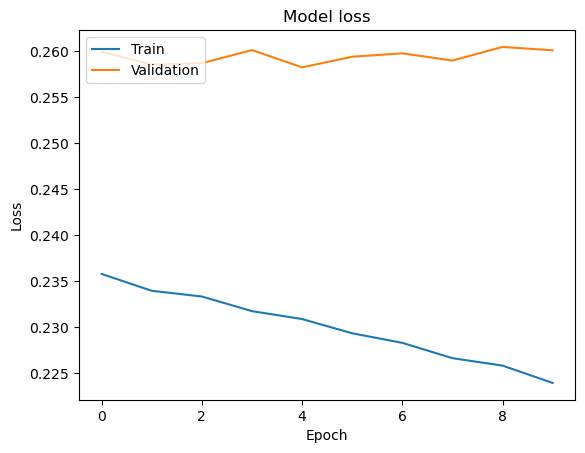

In [4]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


# Preprocessing function
def preprocess(directory_path, img_size=(28, 28)):
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.jpg')]
    images = []
    for img_file in image_files:
        img_path = os.path.join(directory_path, img_file)
        img = Image.open(img_path).convert('L')
        img = img.resize(img_size)
        img_array = np.asarray(img)
        images.append(img_array)
    images = np.array(images, dtype=np.float32) / 255.0  # Normalization
    return np.expand_dims(images, axis=-1)  # Add channel dimension

# Split data into train and validation sets
def split_data(data, train_size=0.9):
    return train_test_split(data, train_size=train_size)

# Create data pairs
def create_pairs(data1, data2):
    pairs = []
    labels = []
    min_len = min(len(data1), len(data2))
    for i in range(min_len):
        pairs.append([data1[i], data2[i]])
        labels.append(1)
        neg_idx = (i + 1) % min_len
        pairs.append([data1[i], data2[neg_idx]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

# Base network
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

# Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

# Load and preprocess images
thermal_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_thermal_train/data')  # Replace with your path
rgb_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_rgb_train/data')  # Replace with your path

# Split data
train_thermal, val_thermal = split_data(thermal_images)
train_rgb, val_rgb = split_data(rgb_images)

# Create pairs
train_pairs, train_labels = create_pairs(train_thermal, train_rgb)
val_pairs, val_labels = create_pairs(val_thermal, val_rgb)

# Siamese Network
input_shape = train_thermal.shape[1:]
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

# Compile and train
#0.001
#siamese_net.compile(optimizer=Adam(), loss='mse')
#siamese_net.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
siamese_net.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
X_train = [train_pairs[:, 0], train_pairs[:, 1]]
X_val = [val_pairs[:, 0], val_pairs[:, 1]]

siamese_net.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=20, batch_size=32)

history = siamese_net.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=10, batch_size=32)

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


batch normalization added below

2023-09-06 15:23:40.294595: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 15:23:40.323666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 15:23:40.741980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-06 15:28:12.360450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-06 15:28:12.360476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168

Epoch 1/20
581/581 [==============================] - 6s 9ms/step - loss: 35.3353 - val_loss: 23.0936
Epoch 2/20
581/581 [==============================] - 5s 9ms/step - loss: 10.9124 - val_loss: 7.5507
Epoch 3/20
581/581 [==============================] - 6s 10ms/step - loss: 5.8684 - val_loss: 2.8135
Epoch 4/20
581/581 [==============================] - 4s 7ms/step - loss: 3.7892 - val_loss: 1.4249
Epoch 5/20
581/581 [==============================] - 4s 7ms/step - loss: 2.5251 - val_loss: 0.9878
Epoch 6/20
581/581 [==============================] - 4s 7ms/step - loss: 1.6673 - val_loss: 0.6405
Epoch 7/20
581/581 [==============================] - 4s 7ms/step - loss: 1.1255 - val_loss: 0.2886
Epoch 8/20
581/581 [==============================] - 5s 8ms/step - loss: 0.7604 - val_loss: 0.2662
Epoch 9/20
581/581 [==============================] - 4s 8ms/step - loss: 0.5929 - val_loss: 0.2808
Epoch 10/20
581/581 [==============================] - 4s 8ms/step - loss: 0.4423 - val_loss: 0.

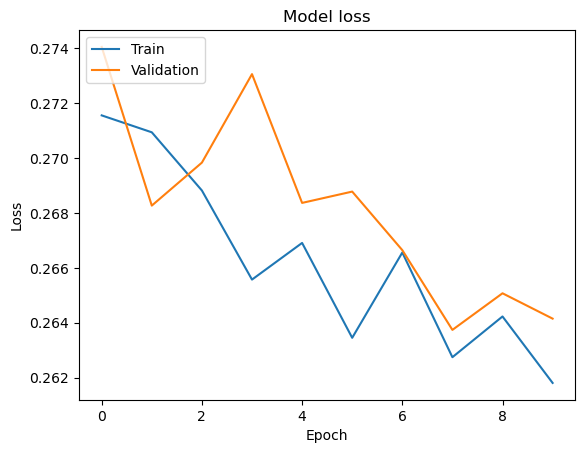

In [1]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation


# Preprocessing function
def preprocess(directory_path, img_size=(28, 28)):
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.jpg')]
    images = []
    for img_file in image_files:
        img_path = os.path.join(directory_path, img_file)
        img = Image.open(img_path).convert('L')
        img = img.resize(img_size)
        img_array = np.asarray(img)
        images.append(img_array)
    images = np.array(images, dtype=np.float32) / 255.0  # Normalization
    return np.expand_dims(images, axis=-1)  # Add channel dimension

# Split data into train and validation sets
def split_data(data, train_size=0.9):
    return train_test_split(data, train_size=train_size)

# Create data pairs
def create_pairs(data1, data2):
    pairs = []
    labels = []
    min_len = min(len(data1), len(data2))
    for i in range(min_len):
        pairs.append([data1[i], data2[i]])
        labels.append(1)
        neg_idx = (i + 1) % min_len
        pairs.append([data1[i], data2[neg_idx]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

from tensorflow.keras.layers import BatchNormalization

# Base network
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3))(input)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Activation('relu')(x)
    
    return Model(inputs=input, outputs=x)

# Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


# Load and preprocess images
thermal_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_thermal_train/data')  # Replace with your path
rgb_images = preprocess('/home/greg/Documents/Siamese_Net/FLIR_ADAS_v2/images_rgb_train/data')  # Replace with your path

# Split data
train_thermal, val_thermal = split_data(thermal_images)
train_rgb, val_rgb = split_data(rgb_images)

# Create pairs
train_pairs, train_labels = create_pairs(train_thermal, train_rgb)
val_pairs, val_labels = create_pairs(val_thermal, val_rgb)

# Siamese Network
input_shape = train_thermal.shape[1:]
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

# Compile and train
#0.001
#siamese_net.compile(optimizer=Adam(), loss='mse')
#siamese_net.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
siamese_net.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
X_train = [train_pairs[:, 0], train_pairs[:, 1]]
X_val = [val_pairs[:, 0], val_pairs[:, 1]]

siamese_net.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=20, batch_size=32)

history = siamese_net.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=10, batch_size=32)

# Calculate and print custom accuracy metric
# Add this line to calculate and print accuracy after training:
y_val_pred = siamese_net.predict(X_val)
val_accuracy = compute_accuracy(val_labels, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()